# Importando Bibliotecas

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import time
import psutil
from tensorflow.keras.callbacks import Callback

# Montando o Diretório



In [3]:
# Diretórios principais
base_dir = "D:\\T.I\\BootcampAvanti_ML\\DeteccaoMelanoma_ML"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Definição dos Parâmetros

In [4]:
# Parâmetros
IMAGE_SIZE = 224
BATCH_SIZE = 32        
EPOCHS = 15          
CHANNELS = 1            


# Carregamento dos dados

In [5]:
# Carregar o dataset de treino
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Carregar o dataset de teste
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [6]:
class_names=train_dataset.class_names
class_names

['Benign', 'Malignant']

In [7]:
len(train_dataset)

372

In [8]:
for image_batch,label_batch in train_dataset.take(1):
    print(label_batch.numpy())
    print(image_batch[0].numpy())

[1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0]
[[[160. 131. 133.]
  [161. 132. 134.]
  [162. 133. 135.]
  ...
  [161. 138. 124.]
  [163. 140. 126.]
  [166. 143. 129.]]

 [[163. 134. 136.]
  [163. 134. 136.]
  [165. 136. 138.]
  ...
  [163. 140. 126.]
  [165. 142. 128.]
  [167. 144. 130.]]

 [[166. 137. 139.]
  [167. 138. 140.]
  [168. 139. 141.]
  ...
  [167. 141. 128.]
  [168. 142. 129.]
  [170. 144. 131.]]

 ...

 [[186. 161. 157.]
  [185. 160. 156.]
  [185. 160. 156.]
  ...
  [165. 135. 133.]
  [165. 135. 133.]
  [166. 136. 134.]]

 [[190. 165. 160.]
  [188. 163. 158.]
  [186. 161. 156.]
  ...
  [166. 135. 132.]
  [165. 134. 131.]
  [166. 135. 132.]]

 [[194. 169. 164.]
  [191. 166. 161.]
  [187. 162. 157.]
  ...
  [166. 135. 132.]
  [166. 135. 132.]
  [166. 135. 132.]]]


# Visualização dos Dados

#### Visualizando os dados

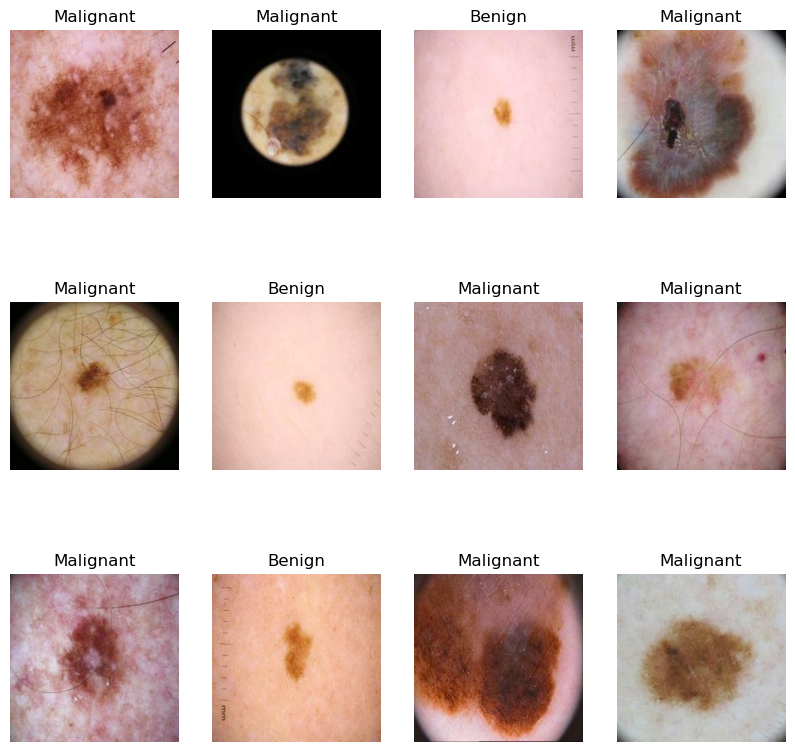

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_dataset.take(1):
    class_names = train_dataset.class_names
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

#### Visualizando os dados com o pré-processamento

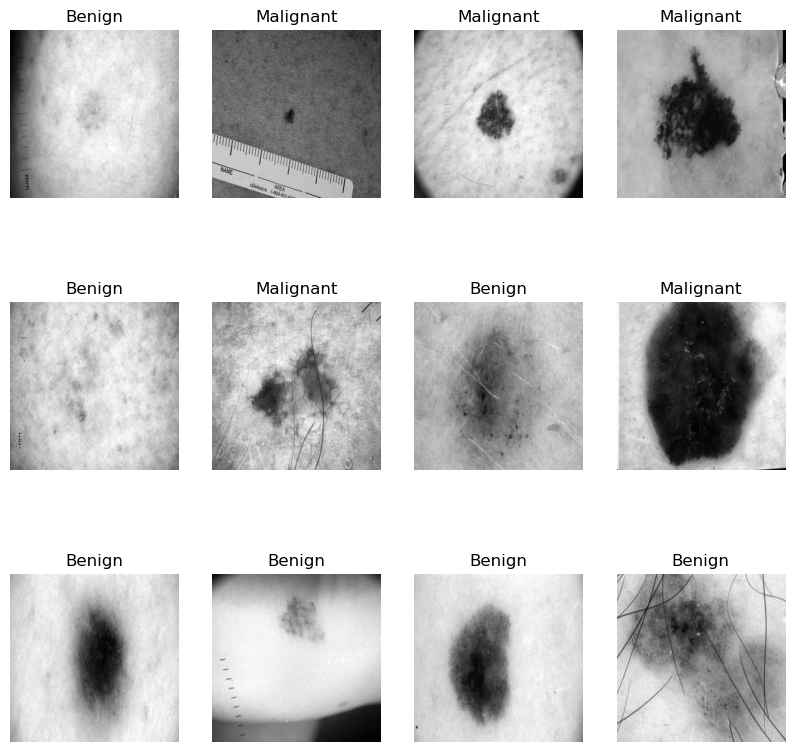

In [17]:
def preprocess_image(image, label):
    # Convertendo para escala de cinza
    image = tf.image.rgb_to_grayscale(image)
    # Normalizando a imagem
    image = image / 255.0
    # Aplica CLAHE
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    # # Equalização de histograma                     # Adicionei recentemente
    # image = tf.image.equalize_histogram(image)      # Adicionei recentemente
    return image, label

# Aplicar o pré-processamento aos datasets
train_dataset_temporario = train_dataset.map(preprocess_image)

plt.figure(figsize=(10,10))
for image_batch, label_batch in train_dataset_temporario.take(1):
    class_names = train_dataset.class_names
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')  # Usar cmap='gray' para escala de cinza
        plt.axis("off")
        plt.title(class_names[label_batch[i]])


In [18]:
# Deletando o train_dataset_temporario

del train_dataset_temporario
import gc
gc.collect()  # Forçar coleta de lixo para liberar a memória

27965

# Particionamento dos Dados

In [9]:
def get_dataset_partitation(ds, train_split=0.8, valid_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + valid_split <= 1), "As proporções de treinamento e validação devem somar no máximo 1"
    
    ds_size = len(ds)
    if ds_size == 0:
        raise ValueError("O dataset está vazio.")
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    valid_size = int(ds_size * valid_split)
    
    if train_size + valid_size > ds_size:
        raise ValueError("Os tamanhos de particionamento excedem o tamanho do dataset.")
    
    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)

    return train_ds, valid_ds

In [10]:
train_ds,valid_ds=get_dataset_partitation(train_dataset)

In [11]:
len(train_ds)

297

In [12]:
len(test_dataset)

63

In [13]:
len(valid_ds)

37

# Otimização do Carregamento de Imagens

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Redimensionando tamanho e escala

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Aumento de Dados (Data Augmentation)

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    # Novos parametros
    layers.RandomZoom(0.2),  # Adiciona zoom
    layers.RandomTranslation(0.2, 0.2),  # Adiciona tradução (opcional, para mais variabilidade)
    #layers.RandomShear(0.2)  # Adiciona shear
])

# Pré-Processamento das imagens

In [17]:
# Criando a camada de pré-processamento personalizada
class PreprocessImageLayer(layers.Layer):
    def __init__(self):
        super(PreprocessImageLayer, self).__init__()

    def call(self, image):
        # Convertendo para escala de cinza
        image = tf.image.rgb_to_grayscale(image)
        # Aplica CLAHE
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        # # Equalização de histograma                     # Adicionei recentemente
        # image = tf.image.equalize_histogram(image)      # Adicionei recentemente / Não funcionou.
        return image

preprocess_image_layer = PreprocessImageLayer()

# Construindo o Modelo

#### Construindo função para monitorar treinamento

In [18]:
class ResourceMonitor(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.process = psutil.Process()
        self.cpu_usages = []
        self.memory_usages = []
        self.logs = {
            "epoch": [],
            "cpu_usage": [],
            "memory_usage": [],
            "elapsed_time": []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Capture CPU and memory usage at the end of each epoch
        cpu_usage = self.process.cpu_percent(interval=None)
        memory_info = self.process.memory_info()
        memory_usage = memory_info.rss / (1024 * 1024)  # Convert bytes to MB
        elapsed_time = time.time() - self.train_start_time
        
        self.cpu_usages.append(cpu_usage)
        self.memory_usages.append(memory_usage)

        # Store in logs
        self.logs["epoch"].append(epoch + 1)
        self.logs["cpu_usage"].append(cpu_usage)
        self.logs["memory_usage"].append(memory_usage)
        self.logs["elapsed_time"].append(elapsed_time)

        print(f"Epoch {epoch + 1}: CPU usage: {cpu_usage}%, Memory usage: {memory_usage} MB, Elapsed time: {elapsed_time:.2f} seconds")
    
    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        self.total_training_time = self.train_end_time - self.train_start_time
        print(f"Total training time: {self.total_training_time:.2f} seconds")
        print(f"Average CPU usage: {sum(self.cpu_usages) / len(self.cpu_usages):.2f}%")
        print(f"Average Memory usage: {sum(self.memory_usages) / len(self.memory_usages):.2f} MB")
        
        # Store final training time
        self.logs["total_training_time"] = self.total_training_time
        self.logs["average_cpu_usage"] = sum(self.cpu_usages) / len(self.cpu_usages)
        self.logs["average_memory_usage"] = sum(self.memory_usages) / len(self.memory_usages)
    
    def get_logs(self):
        return self.logs

### Construção do modelo

In [ ]:
# Testar mais tarde, a mudança foi o drop out

# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 2

# model_64 = tf.keras.Sequential([
#     layers.Input(shape=input_shape),  # Adicionando a forma de entrada
#     preprocess_image_layer,  # Camada de pré-processamento personalizada
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dropout(0.2), # testando drop out
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])

# model_64.build(input_shape=(None,) + input_shape)

# model_64.summary()

#### Modelo com 64 Neurônios

In [19]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model_64 = tf.keras.Sequential([
    layers.Input(shape=input_shape),  # Adicionando a forma de entrada
    preprocess_image_layer,  # Camada de pré-processamento personalizada
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_64.build(input_shape=(None,) + input_shape)

model_64.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess_image_layer          │ (None, 224, 224, 1)    │             0 │
│ (PreprocessImageLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,178 (1.84 MB)

 Trainable params: 482,178 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

#### Modelo com 512 Neurônios

In [ ]:
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 2

# model_512 = tf.keras.Sequential([
#     layers.Input(shape=input_shape),  # Adicionando a forma de entrada
#     preprocess_image_layer,  # Camada de pré-processamento personalizada
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])

# model_512.build(input_shape=(None,) + input_shape)

# model_512.summary()


# Compilando e Treinando o modelo

#### Compilando o modelo

In [20]:
# Compilando o modelo

model_64.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### Instanciação do callback de monitoramento de recursos

In [21]:
resource_monitor = ResourceMonitor()

#### Treinando o modelo

In [22]:
# Treinamento do modelo
history = model_64.fit(
    train_ds,  # Dados de treinamento
    epochs=EPOCHS,  # Número de épocas
    validation_data=valid_ds,  # Dados de validação
    batch_size=BATCH_SIZE,  # Tamanho do lote
    verbose=1,  # Nível de verbosidade
    callbacks=[resource_monitor]
)

# Converter os logs para um DataFrame
logs = resource_monitor.get_logs()
df = pd.DataFrame(logs)
print(df)

Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.6165 - loss: 0.6366Epoch 1: CPU usage: 0.0%, Memory usage: 10019.51953125 MB, Elapsed time: 250.97 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 251s 638ms/step - accuracy: 0.6166 - loss: 0.6365 - val_accuracy: 0.6478 - val_loss: 0.6319
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.6904 - loss: 0.5611Epoch 2: CPU usage: 647.0%, Memory usage: 11944.703125 MB, Elapsed time: 427.67 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 177s 593ms/step - accuracy: 0.6905 - loss: 0.5610 - val_accuracy: 0.7373 - val_loss: 0.5172
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7329 - loss: 0.5156Epoch 3: CPU usage: 644.0%, Memory usage: 10179.234375 MB, Elapsed time: 604.15 seconds
297/297 ━━━━━━━━━━━━━━━━━━━━ 176s 594ms/step - accuracy: 0.7329 - loss: 0.5155 - val_accuracy: 0.7576 - val_loss: 0.4690
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7424 - loss: 0.4970Epoch 4: CPU usage: 662.9

#### Monitorando o Treinamento

- coleta e armazenamento de métricas de uso de recursos do sistema durante o treinamento do modelo

In [23]:
df.to_csv('resource_usage_log_model64_15ep_ppZoom.csv', index=False)

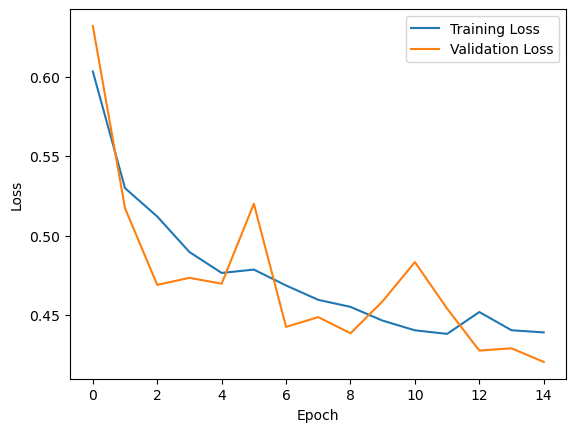

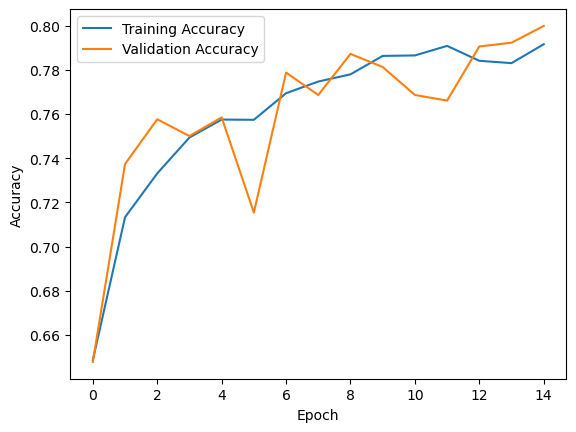

In [24]:
# Plotar a perda de treinamento e validação
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar a acurácia de treinamento e validação
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Salvando o modelo

#### Salvando o modelo completo

In [25]:
# Salvar o modelo completo no formato Keras nativo
model_64.save('model64_15ep_ppZoom.keras')


#### Salvando os pesos

In [ ]:
# Salvar apenas os pesos
model_64.save_weights('meus_pesos_modelo.h5')
# Deu pau kkkkk

# Avaliar o modelo no conjunto de Test

In [26]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model_64.evaluate(test_dataset)
print(f"Perda no teste: {test_loss:.4f}")
print(f"Acurácia no teste: {test_accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.8025 - loss: 0.3983
Perda no teste: 0.4152
Acurácia no teste: 0.7945


In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


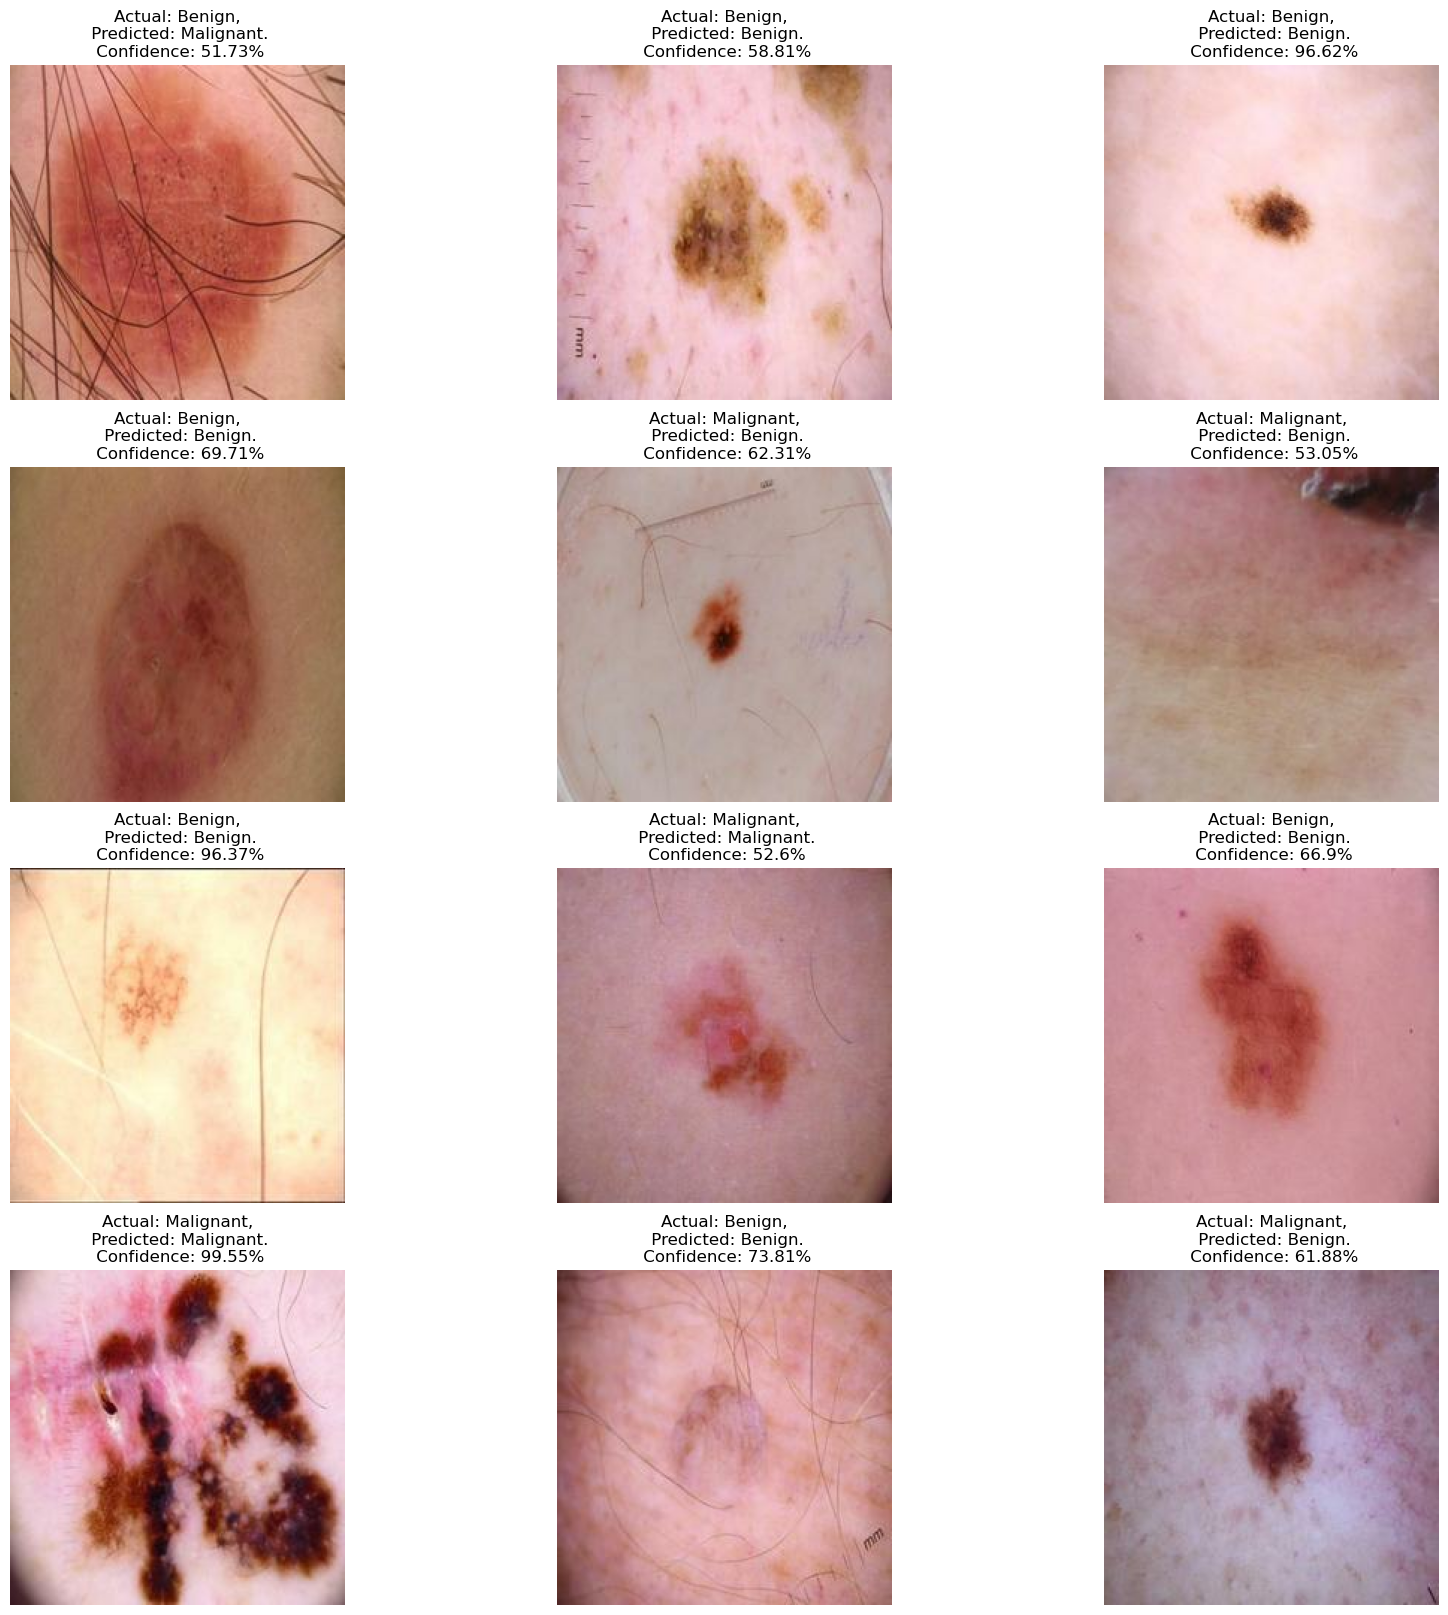

In [28]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_64, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
def evaluate_model(model, test_dataset):
    # Avaliar o modelo no conjunto de teste
    scores = model.evaluate(test_dataset)
    print(f"Loss: {scores[0]}")
    print(f"Accuracy: {scores[1]}")
    
    # Obter previsões
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(model.predict(images), axis=-1))
    
    # Relatório de classificação
    print("Classification Report")
    class_report = classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    metrics = {
        "loss": scores[0],
        "accuracy": scores[1],
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "classification_report": class_report
    }
    
    # Converter as métricas em um DataFrame
    metrics_df = pd.DataFrame([metrics])
    
    return metrics_df

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.8158 - loss: 0.3914
Loss: 0.4067716598510742
Accuracy: 0.8075000047683716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━

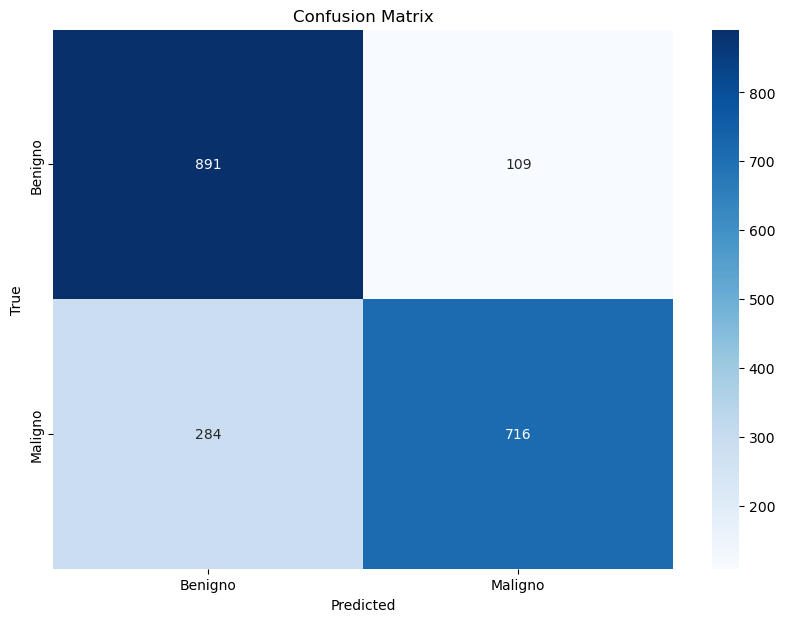

,loss,accuracy,precision,recall,f1_score,classification_report
0,0.406772,0.8075,0.813088,0.8035,0.801984,"{'Benigno': {'precision': 0.7582978723404256, ..."


In [30]:
# Avaliar o modelo e obter as métricas
metrics_df = evaluate_model(model_64, test_dataset)
display(metrics_df)

#### Salvando o relatório

In [31]:
# Salvar o DataFrame em um arquivo CSV
metrics_df.to_csv('model64_15ep_ppZoom_metrics.csv', index=False)

In [ ]:
# # Criar DataFrame com a matriz de confusão
# df_cm = pd.DataFrame(cm, index=['Benign', 'Malignant'], columns=['Benign', 'Malignant'])

# # Salvar o DataFrame como CSV
# df_cm.to_csv('matriz_confusao.csv')

# # Salvar o relatório de classificação como texto
# with open('relatorio_classificacao.txt', 'w') as f:
#     f.write(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))